# CATBOOST 4-class model training


## Libraries, functions and dictionaries

In [47]:
import sys, os

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import random
import seaborn as sns
import re

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score


from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool,cv
from catboost.datasets import titanic

import warnings
warnings.filterwarnings('ignore')

In [48]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_3L_1LC={"Ter":'*',"Gap":'-',"ALA":'A',"CYS":'C',"ASP":'D',"GLU":'E',"PHE":'F',"GLY":'G',"HIS":'H',"ILE":'I',"LYS":'K',"LEU":'L',"MET":'M',"ASN":'N',"PRO":'P',"GLN":'Q',"ARG":'R',"SER":'S',"THR":'T',"VAL" :'V',"TRP":'W',"TYR":'Y'}

alphabetAA_to_classes={'A':1,'C':2,'D':3,'E':3,'F':1,'G':4,'H':3,'I':1,'K':3,'L':1,'M':1,'N':2,'P':4,'Q':2,'R':3,'S':2,'T':2,'V':1,'W':1,'Y':1}
alphabetclasses_to_AA={v: k for k,v in alphabetAA_to_classes.items()}

AA_ddsp_number={'H' :0,'B' : 1,'E' : 2,'G' : 3,'I' : 4,'T' : 5,'S' : 6,' ' : 7}
AA_number_ddsp={v: k for k,v in AA_ddsp_number.items()}

AA_ddsp_number_simp={'H' :0,'E' : 1,'C' : 2}
AA_number_ddsp_simp={v: k for k,v in AA_ddsp_number.items()}

AA_to_hydrophobicity_scores={'A':44,'C':50,'D':-37,'E':-12,'F':96,'G':0,'H':-16,'I':100,'K':-30,'L':99,'M':74,'N':-35,'P':-46,'Q':-14,'R':-20,'S':-6,'T':13,'V':78,'W':90,'Y':57}

### Load functions

In [49]:
def remove_WT_score(score,WT_seq):
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=np.nan
    return score

In [50]:
def load_data_V2(data,wt_seq,start_gap=0,column_score=1):
    df=pd.read_csv(data, delim_whitespace=True, comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,column_score])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    for i in range(len(mutation_load)):
        if  mutation_load[i][len(mutation_load[i])-1]!= '=':
            scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
    return scores

### General functions

In [51]:
def normalize_score(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.percentile(scores[~np.isnan(scores)],5)
    c_max_act=np.percentile(scores[~np.isnan(scores)],95)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [52]:
def normalize_minmax(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.amin(scores[~np.isnan(scores)])
    c_max_act=np.amax(scores[~np.isnan(scores)])
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [53]:
def normalize_fermi(scores):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=1/(sp.exp(scores[i,j]-2)+1)                 
    return normalized_scores

In [54]:
def normalize_cutoff(scores,lowcut,highcut):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            if scores[i,j] < lowcut:
                normalized_scores[i,j]=lowcut
            elif scores[i,j] > highcut:
                normalized_scores[i,j]=highcut
            else:
                normalized_scores[i,j]=scores[i,j]
    return normalized_scores

In [55]:
def position_mean(score):
    score_mean=np.zeros(score.shape[0],dtype=float)
    for i in range(score.shape[0]):
        count=0
        flag_nan=True
        for j in range(score.shape[1]):
            if np.isnan(score[i,j])==False:
                flag_nan=False
                score_mean[i]+=score[i,j]
                count+=1
            else:
                pass
        if flag_nan==True:
            score_mean[i]=np.nan
        score_mean[i]/=count
        
    return score_mean

In [56]:
def position_mean(score):
    score_mean=np.zeros(score.shape[0],dtype=float)
    for i in range(score.shape[0]):
        score_mean[i]=np.nanmean(score[i,:])
        
    return score_mean

In [57]:
def position_median(score):
    score_mean=np.zeros(score.shape[0],dtype=float)
    for i in range(score.shape[0]):
        count=0
        
        score_mean[i]=np.nanmedian(score[i,:])
        
    return score_mean

In [58]:
def score_histogram(score,nbin,color,label_x,norm_bool,thr):

    counts, bins = np.histogram(score[~np.isnan(score)],bins=nbin)
    if norm_bool=='Density':
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color, alpha=0.7,edgecolor="black",density=True)
        plt.ylabel('Normalized counts',fontsize=20)
    elif norm_bool=='True':
        
        norm= counts / np.linalg.norm(counts)
        plt.hist(bins[:-1], bins, weights=norm, facecolor=color, alpha=0.7,edgecolor="black")
        plt.ylabel('Normalized counts',fontsize=20)
    else:
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color,edgecolor="black")
        plt.ylabel('Counts',fontsize=20)

    plt.xlabel(label_x,fontsize=20)
    plt.xticks(fontsize=18)
    plt.grid(axis="y",alpha=0.4,linestyle='--')
    sum_unstable=0
    for i in range(len(bins)-1):
        if bins[i+1] < thr:
            sum_unstable+=counts[i]
    print('Wt-like variants:',np.sum(counts)-sum_unstable, ' (', (np.sum(counts)-sum_unstable)/np.sum(counts) ,')')
    
    #plt.show()

In [59]:
def heatmap_IBS(prediction,variant_map,WT):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1

    fig, ax = plt.subplots(figsize=(16,6))
    ylabels=[ alphabetAA_D_L[i] for i in range(1,21)]
    
    ax.imshow(np.transpose(scores), aspect = 'auto', cmap=mpl.colors.ListedColormap(["white","#56b4e9"]))

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels,fontsize=15)
    ax.tick_params(axis='x', which='major', labelsize=15)
        
    tmp=np.empty((len(WT),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT)):
        tmp[i,alphabetAA_L_D[WT[i]]-1]=1
    plt.imshow(tmp.T, cmap='Accent', aspect = 'auto')
    
    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("mutation",fontsize=16)
    plt.xlabel("residue",fontsize=16)

    plt.ylim(-0.5,19.5)

In [60]:
def ratio_variants(mave_funct,mave_abd):
    ratio=np.copy(mave_funct)
    ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(mave_funct[i,j]) or np.isnan(mave_abd[i,j]):
                pass
            else:
                if mave_abd[i,j]==0.0:
                    ratio[i,j]=mave_funct[i,j]/0.0000001
                else:
                    ratio[i,j]=mave_funct[i,j]/mave_abd[i,j]
    sig_ratio=np.copy(ratio)
    sig_ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(ratio[i,j])!=True:
                sig_ratio[i,j]=1/(1+np.exp(-(ratio[i,j]-1)))

    return sig_ratio

In [61]:
def MCC_test_subset(prediction,test):
    TP=0
    FP=0
    total=0
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if int(test[i])==1:
                total+=1
    precision=TP/(TP+FP)
    recall=TP/total
    mcc=np.sqrt(abs(precision*recall))
    
    return precision,recall,mcc                 

In [62]:
def MCC_test_subset(prediction,test):
    TP=0
    FP=0
    total=0
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if int(test[i])==1:
                total+=1
    precision=TP/(TP+FP)
    recall=TP/total
    mcc=np.sqrt(abs(precision*recall))
    F1 = 2 * (precision*recall)/(precision+recall)
    
    return precision,recall,mcc  ,F1               

In [63]:
def MCC_test_multi(prediction,test):
    mcc=[]
    temp=[]
    for v in range(3):
        TP=0
        FP=0
        total=0
        mcc=[]
        for i in range(len(prediction)):
            if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
                if prediction[i]==v:
                    if int(prediction[i])==int(test[i]):
                        TP+=1
                    else:
                        FP+=1
                if int(test[i])==v:
                    total+=1
        if (FP+TP)==0:
            precision=0
        else:
            precision=TP/(TP+FP)
        if total ==0:
            recall =0
        else:
            recall=TP/total
        temp.append(np.sqrt(abs(precision*recall)))
    mcc=[i for i in temp]
    
    return mcc

In [64]:
def AUC_subset(prediction,test):
    TP=0
    FP=0
    FN=0
    TN=0
    
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if prediction[i]!=1:
                if int(prediction[i])==int(test[i]):
                    TN+=1
                else:
                    FN+=1 
                    
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    
    return [TPR,FPR]

In [65]:
def retrieve_residue_label_pred_training(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage_mode=np.zeros((len(WT),2),dtype=float)
    
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            count_1=0
            for j in range(scores.shape[1]):
                if scores[i,j]==1:
                    count_1+=1
            percentage=count_1/count
            
            if percentage > percentage_threshold:
                pseudomode_value_class[i]=1
            else:
                pseudomode_value_class[i]=0
            
            percentage_mode[i,0]=percentage
            percentage_mode[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage_mode

In [66]:
def retrieve_residue_label_pred(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    
    count_pos=np.zeros((len(WT),4),dtype=float)
    
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage=np.zeros((len(WT),2),dtype=float)
        
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            for j in range(scores.shape[1]):
                    if np.isnan(scores[i,j])!=True:
                        count_pos[i,int(scores[i,j])]+=1
            count_pos=count_pos/count
            if np.any(count_pos[i,:]>=0.50):
                pseudomode_value_class[i]=np.argmax(count_pos[i,:])
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),pseudomode_value_class[i])


            else:                
                pseudomode_value_class[i]=5
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),'else',pseudomode_value_class[i])
                ## 5 indicates mixed signal with no predominat mutation class
            
            percentage[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage

In [67]:
def pairplot_features(list_feature,name_features,namefile):
    df=pd.DataFrame(list_feature,columns=name_features)
    sns_plot=sns.pairplot(df)
    sns_plot.savefig(namefile)

In [68]:
def print_chimera_attribute_file(attribute_check,attribute,file):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s\n%s\n%s\n' % ( 'attribute: cbyvalue','match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True:
            file.write("\t%s%d%s\t%f\n" % (':',i+1,'.A',-1))
        else:
            file.write("\t%s%d%s\t%f\n" % (':',i+1,'.A',attribute[i]))
    file.close()

In [69]:
def print_chimera_x_attribute_file(attribute_check,attribute,file):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s\n%s\n%s\n' % ( 'attribute: cbyvalue','match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True:
            pass
        else:
            file.write("\t%s%d\t%f\n" % ('/A:',i+1,attribute[i]))
    file.close()

In [70]:
def plot_attributes(pos,pred,variant_map,gemme,rosetta,wcn,gemme_n,rosetta_n):
    
    label_position=np.empty(20,dtype=float)
    label_position[:]=np.nan
    
    i=0
    for cord in variant_map:
        if cord[0]==pos:
            label_position[cord[1]]=prediction[i]
        i+=1
    
    fig,(ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(1,6,figsize=(9,4),gridspec_kw={"width_ratios" : [7,1,1,1,1,1], "wspace" : 0.4})
    cdict = {1: 'blue', 0: 'red'}
    glabel={1.0:'SBI',0.0:'non-SBI'}
    for g in np.unique(label_position):
        if np.isnan(g)!=True:
            ix = np.where(label_position == g)
            ax1.scatter(rosetta[pos,ix],gemme[pos,ix],c=cdict[g], label=[glabel[g]])
    
    ax2.bar(x=0.5,height=wcn[pos])
    ax3.bar(x=0.5,height=np.mean(gemme[pos,:][~np.isnan(gemme[pos,:])]))
    ax4.bar(x=0.5,height=np.mean(rosetta[pos,:][~np.isnan(rosetta[pos,:])]))   
    ax5.bar(x=0.5,height=gemme_n[pos])
    ax6.bar(x=0.5,height=rosetta_n[pos])
    
    
    ax1.set_title('variants classification')
    ax2.set_title('WCN')
    ax3.set_title(r'$\bar{G}$')
    ax4.set_title(r'$\bar{r}$')
    ax5.set_title(r'G_n')
    ax6.set_title(r'r_n')
    
    ax1.set_xlabel('rosetta_score',fontsize=13)
    ax1.set_ylabel('GEMME score',fontsize=13)
    ax1.set_xlim(6,-1)
    ax1.set_ylim(-7,1)
    ax2.set_ylim(0,15)
    ax3.set_ylim(0,-8)
    ax4.set_ylim(0,6)
    ax5.set_ylim(0,-8)
    ax6.set_ylim(0,6)
    
    
    ax2.set_xticks([],[])
    ax3.set_xticks([],[])
    ax4.set_xticks([],[])
    ax5.set_xticks([],[])
    ax6.set_xticks([],[])
    ax2.set_xlim(0.1,0.9)
    
    
    
    ax1.legend()

In [71]:
def results_plot(MCC,AUC,name_models):
    
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(14,4))
    
    cdict = {1: '#355070', 2: '#6D597A',2:'#B56576',3 :'#a4d600',4:'#a47f4b',5:'#EAAC8B',6:'#4a944f',7:"#F95738"}
    for g in range(0,7):
        ax1.scatter(AUC[g,1],AUC[g,0],c=cdict[g+1])
    ax1.plot([0, 1], [0, 1], transform=ax1.transAxes,ls=':')
    ax1.set_xlabel('FPR',fontsize=13)
    ax1.set_ylabel('TPR',fontsize=13)
    
    for g in range(0,7):
        ax2.scatter(MCC[g,0],MCC[g,1],c=cdict[g+1], label=g+1)
    #ax2.scatter(MCC[:,0],MCC[:,1],c=color_class)
    
    ax2.set_xlabel('Precision',fontsize=13)
    ax2.set_ylabel('Recall',fontsize=13)
    ax2.legend(loc='lower right')
    
    cbar=[cdict[i] for i in range(1,8)]
    ax3.bar(name_models,MCC[:,2],color=cbar)
    ax3.set_ylabel('MCC',fontsize=13)


In [72]:
def print_percentage_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    print(f' SBI variants: {count_SBI} out of {len(pred)} ({count_SBI/len(pred)*100:.2f}%) ')
    
    perc_variants=count_SBI/len(pred)*100
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    print(f' SBI residues: {count_SBI} out of {effective_pos} ({count_SBI/effective_pos*100:.2f}%) ')
    
    return [perc_variants, count_SBI/effective_pos*100]

In [73]:
def print_numbers_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    variants=count_SBI
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    
    return [variants, count_SBI]

In [74]:
def yellow_model_prediction(prediction,variant_map,experimental_label):
    new_score_region=[0,0,0,0]
    i=0
    for cord in variant_map:
        if experimental_label[cord[0]][0]==3:
            #print(experimental_label[cord[0]][0],prediction[i])
            new_score_region[int(prediction[i][0])]+=1
        else:
            pass
        i+=1
    print(new_score_region)
    return new_score_region/np.sum(new_score_region) 

### setup ML functions

In [75]:
def secondary_structure_cat(pdb_loc,WT):
    pdb=md.load(pdb_loc)
    topology = pdb.topology
    chainA = topology.select('chainid 0  and protein')
    pdb_chainA= pdb.atom_slice(chainA)
    
    chainA_top=pdb_chainA.topology
    
    ss_labels=md.compute_dssp(pdb_chainA,simplified=False)

    ss_ret_labels=np.empty(len(WT),dtype=float)
    ss_ret_labels[:]=np.nan
    
    for i in range(len(ss_labels[0,:])):
        ss_ret_labels[int(str(chainA_top.residue(i))[3:])-1]=AA_ddsp_number[ss_labels[0,i]]
    
    return ss_ret_labels
    

In [76]:
def secondary_structure_cat_simp(pdb_loc,WT):
    pdb=md.load(pdb_loc)
    topology = pdb.topology
    chainA = topology.select('chainid 0  and protein')
    pdb_chainA= pdb.atom_slice(chainA)
    
    chainA_top=pdb_chainA.topology
    
    ss_labels=md.compute_dssp(pdb_chainA,simplified=True)

    ss_ret_labels=np.empty(len(WT),dtype=float)
    ss_ret_labels[:]=np.nan
    count=1
    for j in range(len(WT)):
        if WT[j]!='-':
            for i in range(len(ss_labels[0,:])):
                if count==int(str(chainA_top.residue(i))[3:]):
                    ss_ret_labels[j]=AA_ddsp_number_simp[ss_labels[0,i]]
            count+=1
    return ss_ret_labels
    

In [77]:
def WCN(pdb_loc,scheme_e,WT):
    r0=7.0
    pdb=md.load(pdb_loc)
    topology=pdb.topology
    chainA=topology.select('chainid 0 and protein')
    pdb_chain0=pdb.atom_slice(chainA)
    pdb_dist,pdb_rp=md.compute_contacts(pdb_chain0,scheme=scheme_e,periodic=False)
    
    cm= md.geometry.squareform(pdb_dist,pdb_rp)[0]
    wcn=np.zeros((len(WT)),dtype=float)
    
    cm_adj=np.empty((len(WT),len(WT)),dtype=float)
    cm_adj[:]=np.nan
    chainA_top=pdb_chain0.topology
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i==0 and j==0:
                print(str(chainA_top.residue(i)))
            cm_adj[int(str(chainA_top.residue(i))[3:])-1,int(str(chainA_top.residue(j))[3:])-1]=cm[i,j]
    for i in range(len(WT)):
        nan_flag=True
        for j in range(len(WT)):
            if np.isnan(cm_adj[i,j])!=True and cm_adj[i,j]!=0.0:
                nan_flag=False
                wcn[i]+=(1-(cm_adj[i,j]*10/r0)**6)/(1-(cm_adj[i,j]*10/r0)**12)
        if nan_flag==True:
            wcn[i]=np.nan
    return wcn

In [78]:
def neighbor_scores(score,ext_range):
    score_neighborhood=np.zeros(len(score),dtype=float)
    for i in range(len(score)):
        if np.isnan(score[i])!=True:
            count_nan=0
            if i==0:
                for j in range(1,ext_range+1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range:    
                    score_neighborhood[i]/=(ext_range)
                else:
                    score_neighborhood[i]=np.nan

            elif i==(len(score)-1):
                for j in range(len(score)-1-ext_range,len(score)-1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range: 
                    score_neighborhood[i]/=ext_range
                else:
                    score_neighborhood[i]=np.nan                
            elif i<ext_range:
                for j in range(0,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(i+ext_range):    
                    score_neighborhood[i]/=(i+ext_range)
                else:
                    score_neighborhood[i]=np.nan                        

            elif i>(len(score)-1-ext_range):
                for j in range(i-ext_range,len(score)):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(len(score)-i+ext_range):                     
                    score_neighborhood[i]/=(len(score)-i+ext_range)
                else:
                    score_neighborhood[i]=np.nan  
            else:
                for j in range(i-ext_range,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(2*ext_range):  
                    score_neighborhood[i]/=(2*ext_range)
                else:
                    score_neighborhood[i]=np.nan             
        else:
            score_neighborhood[i]=np.nan
    return score_neighborhood

In [79]:
def label_category(output,threshold):
    labels=[]
    if output.ndim==1:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(len(output)):
            if output[i]<threshold:
                labels[i]=0
            else:
                labels[i]=1
    else:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                if output[i,j]<threshold:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    return labels

In [80]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [81]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [82]:
def features_validation(list_features_x,WT):
    
    X=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
            

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    mapping_pos.append([i,j])
        
    return np.array(X),mapping_pos        

In [83]:
def binary_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    
    return labels

In [84]:
def multiclass_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                elif data_x[i,j] < t_x and data_y[i,j]<t_y:
                    labels[i,j]=2
                elif data_x[i,j] < t_x and data_y[i,j]>t_y:
                    labels[i,j]=3
                else:
                    labels[i,j]=0
    
    return labels

In [85]:
def prob_to_label(probability,thr):
    labels=np.zeros(probability.shape[0],dtype=int)
    for i in range(probability.shape[0]):
        if probability[i][1]>thr:
            labels[i]=1
            #print(1)
        else:
            labels[i]=0
            #print(0)
    return labels

In [86]:
def pairplot_features_class(list_feature,name_features,namefile,class_coloured):
    df=pd.DataFrame(list_feature,columns=name_features)
    if class_coloured==1:
        sns_plot=sns.pairplot(df,vars=name_features[:-1],hue='Y',palette={0:'w',1:'b'})
    elif class_coloured==0:
        sns_plot=sns.pairplot(df,vars=name_features[:-1],hue='Y',palette={-1:'w',0:'r'}) 
    else:
        sns_plot=sns.pairplot(df,vars=name_features[:-1],hue='Y')         
    sns_plot.savefig(namefile)

In [87]:
def AS_CA_distance(CA_coord,AS_pos,target):
    AS_baricenter=np.zeros((3,1),dtype=float)
    
    for i in AS_pos:
        if np.isnan(CA_coord[i-1,:]).any():
            print(f'WARNING - no active site coordinates in pdb for position: {i}')
        else:
            AS_baricenter[0]+=CA_coord[i-1,0]
            AS_baricenter[1]+=CA_coord[i-1,1]
            AS_baricenter[2]+=CA_coord[i-1,2]
        
    AS_baricenter=AS_baricenter/len(AS_pos)

    dist=[-1.0]
    
    if np.isnan(CA_coord[target-1,:]).any():   
        print(f'WARNING - no target coordinates in pdb for position: {target}')
    else:
        dist=sp.sqrt((AS_baricenter[0]-CA_coord[target-1,0])**2+(AS_baricenter[1]-CA_coord[target-1,1])**2+(AS_baricenter[2]-CA_coord[target-1,2])**2)
    
    return dist[0]

## Load training dataset

#### Sequences

In [88]:
CYP2C9_WT_sequence="MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIGIKDISKSLTNLSKVYGPVFTLYFGLKPIVVLHGYEAVKEALIDLGEEFSGRGIFPLAERANRGFGIVFSNGKKWKEIRRFSLMTLRNFGMGKRSIEDRVQEEARCLVEELRKTKASPCDPTFILGCAPCNVICSIIFHKRFDYKDQQFLNLMEKLNENIKILSSPWIQICNNFSPIIDYFPGTHNKLLKNVAFMKSYILEKVKEHQESMDMNNPQDFIDCFLMKMEKEKHNQPSEFTIESLENTAVDLFGAGTETTSTTLRYALLLLLKHPEVTAKVQEEIERVIGRNRSPCMQDRSHMPYTDAVVHEVQRYIDLLPTSLPHAVTCDIKFRNYLIPKGTTILISLTSVLHDNKEFPNPEMFDPHHFLDEGGNFKKSKYFMPFSAGKRICVGEALAGMELFLFLTSILQNFNLKSLVDPKNLDTTPVVNGFASVPPFYQLCFIPV"

In [89]:
CYP2C9_WT_seq_rose="-----------------------------PPGPTPLPVIGNILQIGIKDISKSLTNLSKVYGPVFTLYFGLKPIVVLHGYEAVKEALIDLGEEFSGRGIFPLAERANRGFGIVFSNGKKWKEIRRFSLMTLRNFGMGKRSIEDRVQEEARCLVEELRKTKASPCDPTFILGCAPCNVICSIIFHKRFDYKDQQFLNLMEKLNENIEILSSPWIQVYNNFPALLDYFPGTHNKLLKNVAFMKSYILEKVKEHQESMDMNNPQDFIDCFLMKMEKEKHNQPSEFTIESLENTAVDLFGAGTETTSTTLRYALLLLLKHPEVTAKVQEEIERVIGRNRSPCMQDRSHMPYTDAVVHEVQRYIDLLPTSLPHAVTCDIKFRNYLIPKGTTILISLTSVLHDNKEFPNPEMFDPHHFLDEGGNFKKSKYFMPFSAGKRICVGEALAGMELFLFLTSILQNFNLKSLVDPKNLDTTPVVNGFASVPPFYQLCFIPV"

In [90]:
NUDT15_WT_sequence="MTASAQPRGRRPGVGVGVVVTSCKHPRCVLLGKRKGSVGAGSFQLPGGHLEFGETWEECAQRETWEEAALHLKNVHFASVVNSFIEKENYHYVTILMKGEVDVTHDSEPKNVEPEKNESWEWVPWEELPPLDQLFWGLRCLKEQGYDPFKEDLNHLVGYKGNHL"

In [91]:
PTEN_WT_sequence="MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVYRNNIDDVVRFLDSKHKNHYKIYNLCAERHYDTAKFNCRVAQYPFEDHNPPQLELIKPFCEDLDQWLSEDDNHVAAIHCKAGKGRTGVMICAYLLHRGKFLKAQEALDFYGEVRTRDKKGVTIPSQRRYVYYYSYLLKNHLDYRPVALLFHKMMFETIPMFSGGTCNPQFVVCQLKVKIYSSNSGPTRREDKFMYFEFPQPLPVCGDIKVEFFHKQNKMLKKDKMFHFWVNTFFIPGPEETSEKVENGSLCDQEIDSICSIERADNDKEYLVLTLTKNDLDKANKDKANRYFSPNFKVKLYFTKTVEEPSNPEASSSTSVTPDVSDNEPDHYRYSDTTDSDPENEPFDEDQHTQITKV"

### MAVE datasets:

#### CYP2C9

In [92]:
df=pd.read_csv('../score_maves/CYP2C9_data.csv',sep=',')
mutation_load=np.array(df.iloc[:,0])
score_funct=np.array(df.iloc[:,6])
score_abund=np.array(df.iloc[:,17])

- Functional scores

In [93]:
CYP2C9_function=np.empty((len(CYP2C9_WT_sequence),20),dtype=float)
CYP2C9_function[:]=np.nan

In [94]:
for i in range(len(mutation_load)):
    if score_funct[i] != 'NaN' and (mutation_load[i][-1:])!='~' and mutation_load[i][-1:]!='*' and mutation_load[i][-1:]!='X' and mutation_load[i] !="WT":
        CYP2C9_function[int(mutation_load[i][1:-1])-1, alphabetAA_L_D[mutation_load[i][-1:]]-1]=float(score_funct[i])

- VAMP-seq scores

In [95]:
CYP2C9_abundance=np.empty((len(CYP2C9_WT_sequence),20),dtype=float)
CYP2C9_abundance[:]=np.nan

In [96]:
for i in range(len(mutation_load)):
    if score_abund[i] != 'NaN' and (mutation_load[i][-1:])!='~' and mutation_load[i][-1:]!='*' and mutation_load[i][-1:]!='X' and mutation_load[i] !="WT":
        CYP2C9_abundance[int(mutation_load[i][1:-1])-1, alphabetAA_L_D[mutation_load[i][-1:]]-1]=float(score_abund[i])

#### NUDT15

- Functional scores:

In [97]:
df=pd.read_excel('../score_maves/NUDT15_scores_pnas.xlsx', index_col=0,header=2)
mutation_load=np.array(df.iloc[:,2])
mutation_position=np.array(df.iloc[:,3])
score_funct=np.array(df.iloc[:,7])
score_abund=np.array(df.iloc[:,5])

In [98]:
NUDT15_function=np.empty((len(NUDT15_WT_sequence),20),dtype=float)
NUDT15_function[:]=np.nan

In [99]:
for i in range(len(mutation_load)):
    if score_funct[i] != ' NA':
        NUDT15_function[int(mutation_position[i])-1, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]=float(score_funct[i])

In [100]:
NUDT15_function_norm=normalize_minmax(NUDT15_function)

- VAMP-seq scores

In [101]:
NUDT15_abundance=np.empty((len(NUDT15_WT_sequence),20),dtype=float)
NUDT15_abundance[:]=np.nan

In [102]:
for i in range(len(mutation_load)):
    if score_abund[i] != ' NA':
        NUDT15_abundance[int(mutation_position[i])-1, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]=float(score_abund[i])

In [103]:
NUDT15_abundance_norm=normalize_minmax(NUDT15_abundance)

#### PTEN

- Functional scores:

In [104]:
df = pd.read_excel (r'../score_maves/PTEN_MAVE_act.xlsx', sheet_name='scores',header=1)
mutation_load=np.array(df.iloc[:,0])
score_funct=np.array(df.iloc[:,6])

In [105]:
PTEN_function=np.empty((len(PTEN_WT_sequence),20),dtype=float)
PTEN_function[:]=np.nan

In [106]:
for i in range(len(mutation_load)):
    if score_funct[i] != 'NaN' and (mutation_load[i][-1:])!='~' and mutation_load[i][-1:]!='*':
        PTEN_function[int(mutation_load[i][1:-1])-1, alphabetAA_L_D[mutation_load[i][-1:]]-1]=float(score_funct[i])

In [107]:
PTEN_function_norm=normalize_minmax(PTEN_function)

- VAMP-seq scores

In [108]:
df=pd.read_csv('../score_maves/PTEN_VAMP_seq.csv',sep=',')
mutation_load=np.array(df.iloc[:,2],dtype=str)
score_abund=np.array(df.iloc[:,3])

In [109]:
PTEN_abundance=np.empty((len(PTEN_WT_sequence),20),dtype=float)
PTEN_abundance[:]=np.nan

In [110]:
for i in range(len(mutation_load)):
    if score_abund[i] != 'NaN' and mutation_load[i][-1:]!='=' and alphabetAA_3L_1L[mutation_load[i][-3:]]!='*':  
        PTEN_abundance[int(mutation_load[i][5:-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]=float(score_abund[i])

In [111]:
PTEN_abundance_norm=normalize_minmax(PTEN_abundance)

### COMPUTATIONAL datasets:

#### NUDT15

- GEMME

In [113]:
NUDT15_GEMME=load_data_V2('../scores_GEMME/prism_gemme_Q9NV35.txt',NUDT15_WT_sequence)
NUDT15_GEMME=remove_WT_score(NUDT15_GEMME,NUDT15_WT_sequence)

In [114]:
NUDT15_GEMME_mean=position_mean(NUDT15_GEMME)

- Rosetta ddG

In [116]:
NUDT15_rosetta_ddg=load_data_V2('../scores_rosetta/prism_rosetta_ddg_Q9NV35.txt',NUDT15_WT_sequence)
NUDT15_rosetta_ddg=NUDT15_rosetta_ddg/2.9
NUDT15_rosetta_ddg=remove_WT_score(NUDT15_rosetta_ddg,NUDT15_WT_sequence)

In [117]:
NUDT15_rosetta_ddg_norm=normalize_cutoff(NUDT15_rosetta_ddg,0.0,5.0)

In [118]:
NUDT15_rosetta_ddg_mean=position_mean(NUDT15_rosetta_ddg_norm)

Wt-like variants: 1243  ( 0.44031172511512573 )


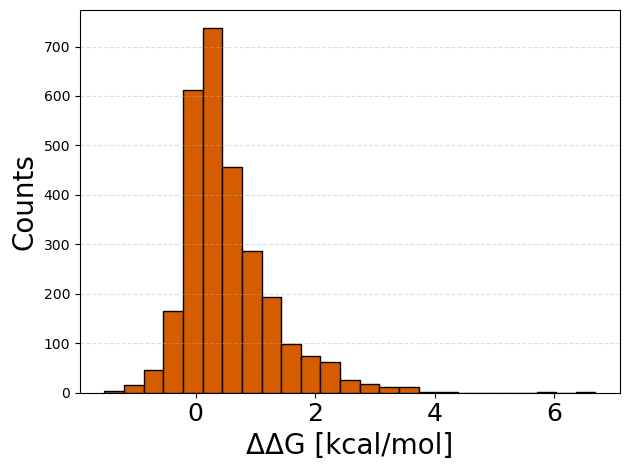

In [120]:
score_histogram(NUDT15_rosetta_ddg,25,'#d55c00','\u0394\u0394G [kcal/mol]',True,0.5)
plt.tight_layout()
#plt.savefig('./Figures/NUDT15_rosetta_pre_norm.pdf')

Wt-like variants: 1318  ( 0.4668792065178888 )


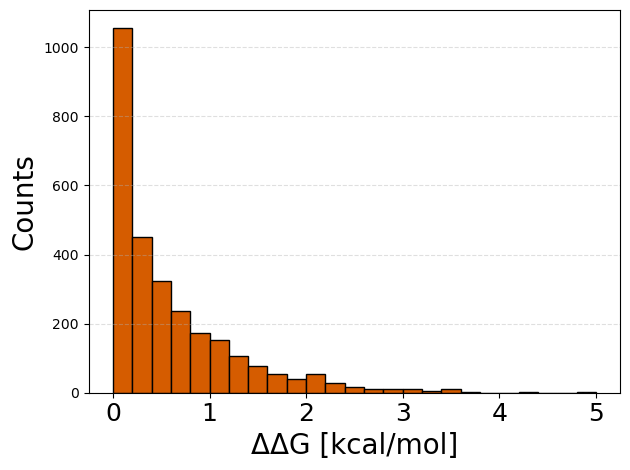

In [121]:
score_histogram(NUDT15_rosetta_ddg_norm,25,'#d55c00','\u0394\u0394G [kcal/mol]',True,0.5)
plt.tight_layout()
#plt.savefig('./Figures/NUDT15_rosetta_post_norm.pdf')

#### PTEN

In [123]:
PTEN_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P60484.txt',PTEN_WT_sequence)
PTEN_GEMME=remove_WT_score(PTEN_GEMME,PTEN_WT_sequence)

In [124]:
PTEN_GEMME_mean=position_mean(PTEN_GEMME)

- Rosetta ddG

In [125]:
PTEN_rosetta_ddg=load_data_V2('../scores_rosetta/prism_rosetta_ddg_P60484.txt',PTEN_WT_sequence)
PTEN_rosetta_ddg=PTEN_rosetta_ddg
PTEN_rosetta_ddg=remove_WT_score(PTEN_rosetta_ddg,PTEN_WT_sequence)

In [126]:
PTEN_rosetta_ddg_norm=normalize_cutoff(PTEN_rosetta_ddg,0.0,5.0)

In [127]:
PTEN_rosetta_ddg_mean=position_mean(PTEN_rosetta_ddg_norm)

Wt-like variants: 4178  ( 0.7538794658967881 )


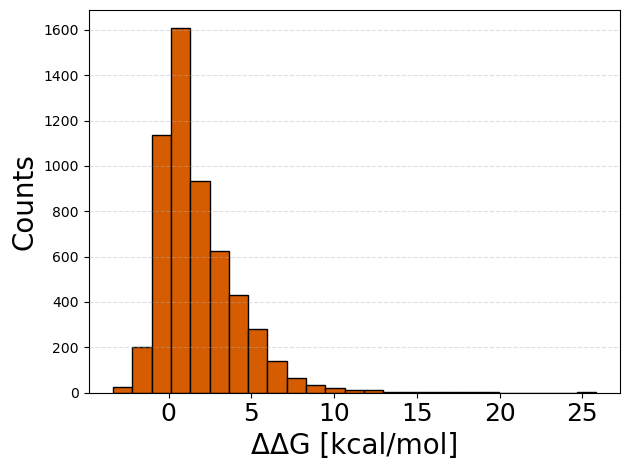

In [128]:
score_histogram(PTEN_rosetta_ddg,25,'#d55c00','\u0394\u0394G [kcal/mol]',True,0.5)
plt.tight_layout()
#plt.savefig('./Figures/PTEN_rosetta_pre_norm.pdf')

Wt-like variants: 3735  ( 0.673944424395525 )


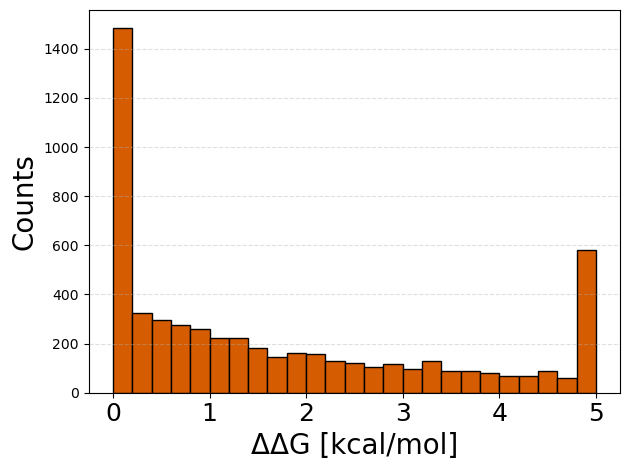

In [129]:
score_histogram(PTEN_rosetta_ddg_norm,25,'#d55c00','\u0394\u0394G [kcal/mol]',True,0.5)
plt.tight_layout()
#plt.savefig('./Figures/PTEN_rosetta_post_norm.pdf')

#### CYP2C9

- Co-evolution

In [131]:
CYP2C9_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P11712.txt',CYP2C9_WT_sequence)
CYP2C9_GEMME=remove_WT_score(CYP2C9_GEMME,CYP2C9_WT_sequence)

In [132]:
CYP2C9_GEMME_mean=position_mean(CYP2C9_GEMME)

-  Rosetta ddG

In [133]:
CYP2C9_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P11712.txt",CYP2C9_WT_seq_rose,29)
CYP2C9_rosetta_ddg=remove_WT_score(CYP2C9_rosetta_ddg,CYP2C9_WT_seq_rose)

In [134]:
CYP2C9_rosetta_ddg_norm=normalize_cutoff(CYP2C9_rosetta_ddg,0,5)

In [135]:
CYP2C9_rosetta_ddg_mean=position_mean(CYP2C9_rosetta_ddg_norm)

Wt-like variants: 6821  ( 0.7787418655097614 )


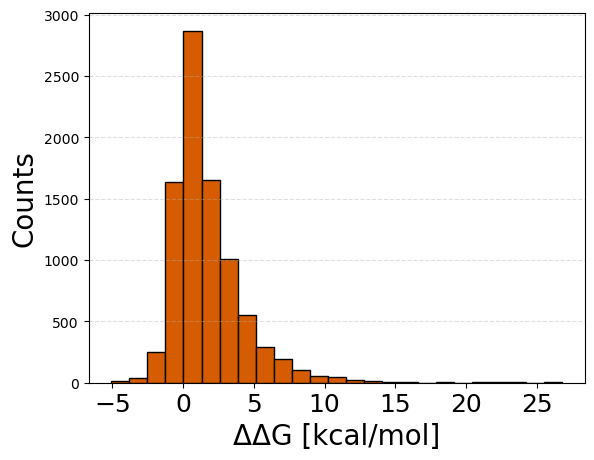

In [136]:
score_histogram(CYP2C9_rosetta_ddg,25,'#d55c00','\u0394\u0394G [kcal/mol]',True,0.5)

Wt-like variants: 5937  ( 0.6778171024089508 )


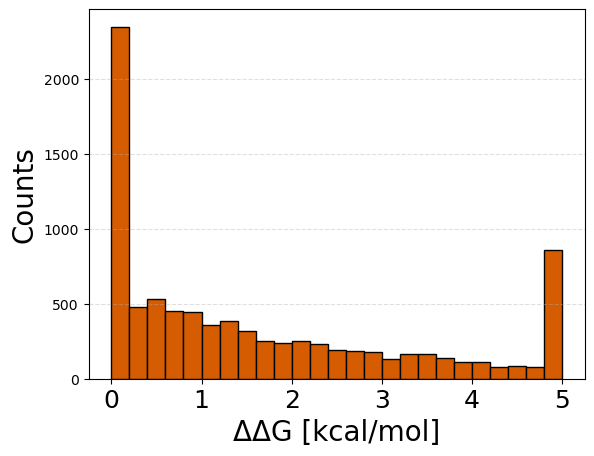

In [137]:
score_histogram(CYP2C9_rosetta_ddg_norm,25,'#d55c00','\u0394\u0394G [kcal/mol]',True,0.5)

### CAVITY

In [138]:
NUDT15_cavity_ddg=load_data_V2('../score_RaSP/prism_cavity_Q9NV35_5lpgA.txt',NUDT15_WT_sequence,column_score=2)

In [139]:
NUDT15_cavity_ddg_norm=normalize_cutoff(NUDT15_cavity_ddg,0.0,5.0)

In [140]:
NUDT15_cavity_ddg_mean=position_mean(NUDT15_cavity_ddg_norm)

In [141]:
NUDT15_cavity_ddg.shape

(164, 20)

Wt-like variants: 2483  ( 0.8377192982456141 )


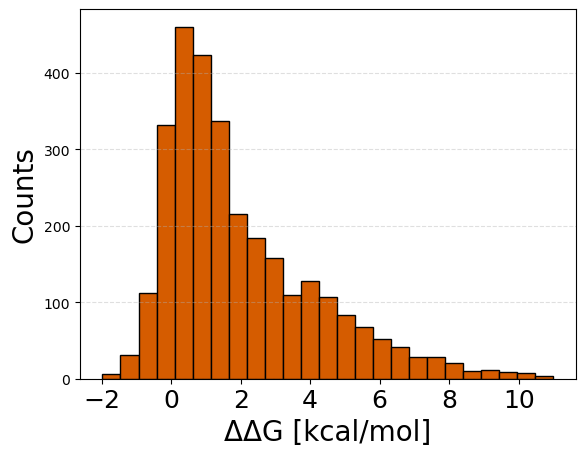

In [142]:
score_histogram(NUDT15_cavity_ddg,25,'#d55c00','\u0394\u0394G [kcal/mol]',True,0.5)

In [143]:
PTEN_cavity_ddg=load_data_V2('../score_RaSP/prism_cavity_P60484_1d5rA.txt',PTEN_WT_sequence,column_score=2)

In [144]:
PTEN_cavity_ddg_norm=normalize_cutoff(PTEN_cavity_ddg,0.0,5.0)

In [145]:
PTEN_cavity_ddg_mean=position_mean(PTEN_cavity_ddg_norm)

In [146]:
PTEN_cavity_ddg_mean.shape

(403,)

Wt-like variants: 4621  ( 0.7922166980970341 )


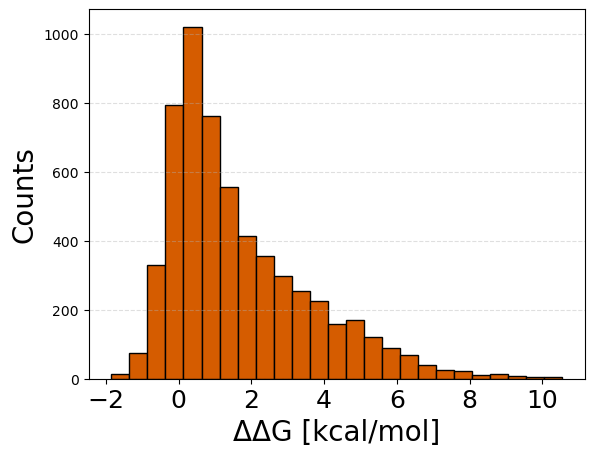

In [147]:
score_histogram(PTEN_cavity_ddg,25,'#d55c00','\u0394\u0394G [kcal/mol]',True,0.5)

In [148]:
CYP2C9_cavity_ddg=load_data_V2('../score_RaSP/prism_cavity_P11712_1og5A.txt',CYP2C9_WT_sequence,column_score=2)

In [149]:
CYP2C9_cavity_ddg_norm=normalize_cutoff(CYP2C9_cavity_ddg,0.0,5.0)

In [150]:
CYP2C9_cavity_ddg_mean=position_mean(CYP2C9_cavity_ddg_norm)

In [151]:
CYP2C9_cavity_ddg_mean.shape

(490,)

Wt-like variants: 7068  ( 0.806941431670282 )


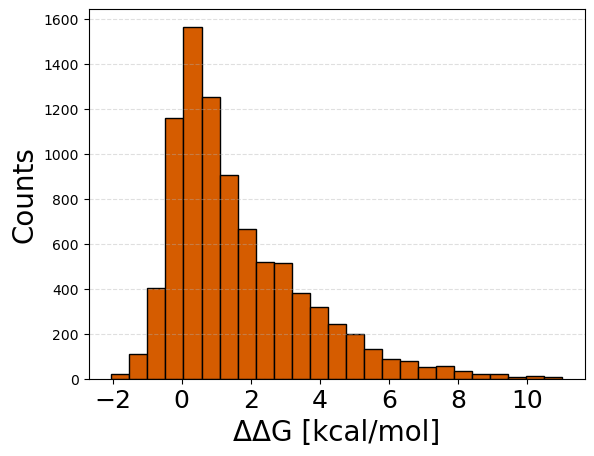

In [152]:
score_histogram(CYP2C9_cavity_ddg,25,'#d55c00','\u0394\u0394G [kcal/mol]',True,0.5)

### Hydrophobicity

#### NUDT15

In [153]:
NUDT15_hydrophobicity_mut=np.empty((len(NUDT15_WT_sequence),20),dtype=float)
NUDT15_hydrophobicity_mut[:]=np.nan

In [154]:
for i in range(len(NUDT15_WT_sequence)):
    for j in range(20):
        NUDT15_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### PTEN

In [155]:
PTEN_hydrophobicity_mut=np.empty((len(PTEN_WT_sequence),20),dtype=float)
PTEN_hydrophobicity_mut[:]=np.nan

In [156]:
for i in range(len(PTEN_WT_sequence)):
    for j in range(20):
        PTEN_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### CYP2C9

In [157]:
CYP2C9_hydrophobicity_mut=np.empty((len(CYP2C9_WT_sequence),20),dtype=float)
CYP2C9_hydrophobicity_mut[:]=np.nan

In [158]:
for i in range(len(CYP2C9_WT_sequence)):
    for j in range(20):
        CYP2C9_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

### WCN

In [160]:
NUDT15_wcn=WCN('../pdbs/Q9NV35_5lpg.pdb','ca',NUDT15_WT_sequence)

GLY9


In [161]:
PTEN_wcn=WCN('../pdbs/P60484_1d5r.pdb','ca',PTEN_WT_sequence)

ARG14


In [162]:
CYP2C9_wcn=WCN('../pdbs/P11712_1og5.pdb','ca',CYP2C9_WT_sequence)

PRO30


### Neighbor sequences scores:


In [163]:
NUDT15_rosetta_neigbor_scores=neighbor_scores(NUDT15_rosetta_ddg_mean,1)

NUDT15_GEMME_neigbor_scores=neighbor_scores(NUDT15_GEMME_mean,1)

PTEN_rosetta_neigbor_scores=neighbor_scores(PTEN_rosetta_ddg_mean,1)

PTEN_GEMME_neigbor_scores=neighbor_scores(PTEN_GEMME_mean,1)

CYP2C9_rosetta_neigbor_scores=neighbor_scores(CYP2C9_rosetta_ddg_mean,1)

CYP2C9_GEMME_neigbor_scores=neighbor_scores(CYP2C9_GEMME_mean,1)

In [164]:
NUDT15_cavity_neigbor_scores=neighbor_scores(NUDT15_cavity_ddg_mean,1)

CYP2C9_cavity_neigbor_scores=neighbor_scores(CYP2C9_cavity_ddg_mean,1)

PTEN_cavity_neigbor_scores=neighbor_scores(PTEN_cavity_ddg_mean,1)

### Threshold definition (classification): 

In [165]:
NUDT15_labels=multiclass_threshold(NUDT15_abundance,NUDT15_function,0.38,0.51)
PTEN_labels=multiclass_threshold(PTEN_abundance,PTEN_function,0.54,-0.9)
CYP2C9_labels=multiclass_threshold(CYP2C9_abundance,CYP2C9_function,0.38,0.40)

In [166]:
count_nonan=0
count_sbi=0
for vec in [NUDT15_labels,PTEN_labels,CYP2C9_labels]:
    for i in range(vec.shape[0]):
        for j in range(vec.shape[1]):
            if np.isnan(vec[i,j])!=True:
                count_nonan+=1
                if vec[i,j]==1.:
                    count_sbi+=1

print(count_nonan,count_sbi, count_sbi/count_nonan)

11335 1981 0.17476841640935156


In [167]:
NUDT15_labels_mode,NUDT15_counts=sp.stats.mode(NUDT15_labels,axis=1)
PTEN_labels_mode,PTEN_counts=sp.stats.mode(PTEN_labels,axis=1)
CYP2C9_labels_mode,CYP2C9_counts=sp.stats.mode(CYP2C9_labels,axis=1)

### Training

In [175]:
NUDT15_Xcav,NUDT15_Ycav,NUDT15_mapcav=features_classification([NUDT15_GEMME, NUDT15_cavity_ddg_norm,NUDT15_GEMME_mean,NUDT15_cavity_ddg_mean,NUDT15_hydrophobicity_mut,NUDT15_GEMME_neigbor_scores,NUDT15_cavity_neigbor_scores,NUDT15_wcn],[NUDT15_labels],NUDT15_WT_sequence)

In [176]:
PTEN_Xcav,PTEN_Ycav,PTEN_mapcav=features_classification([PTEN_GEMME, PTEN_cavity_ddg_norm,PTEN_GEMME_mean,PTEN_cavity_ddg_mean,PTEN_hydrophobicity_mut,PTEN_GEMME_neigbor_scores,PTEN_cavity_neigbor_scores,PTEN_wcn],[PTEN_labels],PTEN_WT_sequence)

In [177]:
CYP2C9_Xcav,CYP2C9_Ycav,CYP2C9_mapcav=features_classification([CYP2C9_GEMME, CYP2C9_cavity_ddg_norm,CYP2C9_GEMME_mean,CYP2C9_cavity_ddg_mean,CYP2C9_hydrophobicity_mut,CYP2C9_GEMME_neigbor_scores,CYP2C9_cavity_neigbor_scores,CYP2C9_wcn],[CYP2C9_labels],CYP2C9_WT_sequence)

In [178]:
X_cav=np.concatenate((NUDT15_Xcav,PTEN_Xcav,CYP2C9_Xcav))
print(len(X_cav))
Y_cav=np.concatenate((NUDT15_Ycav,PTEN_Ycav,CYP2C9_Ycav))
print(len(Y_cav))

9964
9964


In [179]:
cat_cav=CatBoostClassifier(iterations=1000, random_strength= 1, depth= 7, l2_leaf_reg= 9, bagging_temperature= 2,verbose=0,class_weights={0:1,1:2,2:1,3:0.1},random_seed=np.random.randint(0,1000))

In [180]:
cat_cav.fit(X_cav,Y_cav)

In [190]:
MCC=[0,0,0,0]
MCC_multi=[]
count=0
for train_index, test_index in kfold.split(X_cav, Y_cav):
    X_train, X_test = X_cav[train_index], X_cav[test_index]
    Y_train, Y_test = Y_cav[train_index], Y_cav[test_index]
    
    cat_cav.fit(X_train,Y_train)
    prediction=cat_cav.predict(X_test)

    MCC[0]+=MCC_test_subset(prediction,Y_test)[0]
    MCC[1]+=MCC_test_subset(prediction,Y_test)[1]
    MCC[2]+=MCC_test_subset(prediction,Y_test)[2] 
    MCC[3]+=MCC_test_subset(prediction,Y_test)[3]
    MCC_multi.append(MCC_test_multi(prediction,Y_test))
    
    count+=1
    
print("MCC: ",MCC[0]/count,MCC[1]/count,MCC[2]/count,MCC[3]/count)


MCC:  0.5195680786671614 0.5742038264765537 0.5460044061144308 0.5451252409280288


In [184]:
#cat_cav.save_model('../notebooks/outputs/cat_gemme_af_cavity_***date***',format='cbm')

In [181]:
prediction=cat_cav.predict(PTEN_Xcav)

In [182]:
PTEN_MCC_compare.append(['variant_cavity_trained',MCC_test_multi(prediction,np.array(PTEN_Ycav))])

In [183]:
mode_prediction,percentage=retrieve_residue_label_pred(prediction,PTEN_mapcav,PTEN_WT_sequence,0.50)

In [743]:
PTEN_y_pred=yellow_model_prediction(prediction,PTEN_mapcav,PTEN_Ycav)

[125, 33, 75, 0]


In [179]:
sum_class=[0,0,0,0]
for i,n in enumerate(prediction):
    sum_class[int(n)]+=1
print(sum_class)
print(sum_class/np.sum(sum_class))

[1700, 660, 737, 0]
[0.54891831 0.21310946 0.23797223 0.        ]


In [745]:
PTEN_MCC_compare.append(['position_cavity',MCC_test_multi(mode_prediction,PTEN_labels_mode)])

In [746]:
for i,n in enumerate(mode_prediction):
    if n==2:
        print("/A:",i+1," ",sep="",end="")

/A:28 /A:35 /A:53 /A:56 /A:57 /A:61 /A:65 /A:67 /A:68 /A:88 /A:95 /A:96 /A:98 /A:100 /A:104 /A:105 /A:107 /A:108 /A:111 /A:112 /A:118 /A:119 /A:120 /A:122 /A:133 /A:135 /A:137 /A:138 /A:139 /A:140 /A:141 /A:148 /A:151 /A:152 /A:154 /A:155 /A:170 /A:174 /A:175 /A:177 /A:178 /A:179 /A:182 /A:188 /A:193 /A:195 /A:204 /A:215 /A:217 /A:239 /A:241 /A:243 /A:247 /A:252 /A:253 /A:255 /A:257 /A:270 /A:271 /A:274 /A:275 /A:276 /A:277 /A:278 /A:279 /A:280 /A:320 /A:325 /A:337 /A:343 /A:345 /A:347 

In [747]:
prediction=cat_cav.predict(NUDT15_Xcav)

In [748]:
NUDT15_MCC_compare.append(['variant_cavity',MCC_test_multi(prediction,np.array(NUDT15_Ycav))])

In [749]:
NUDT15_y_pred=yellow_model_prediction(prediction,NUDT15_mapcav,NUDT15_Ycav)

[296, 42, 71, 2]


In [750]:
sum_class=[0,0,0,0]
for i,n in enumerate(prediction):
    sum_class[int(n)]+=1
print(sum_class)
print(sum_class/np.sum(sum_class))

[1824, 314, 556, 9]
[0.67480577 0.11616722 0.20569737 0.00332963]


In [751]:
mode_prediction,percentage=retrieve_residue_label_pred(prediction,NUDT15_mapcav,NUDT15_WT_sequence,0.50)

In [752]:
NUDT15_MCC_compare.append(['position_cavity',MCC_test_multi(mode_prediction,NUDT15_labels_mode)])

In [753]:
for i,n in enumerate(mode_prediction):
    if n==1:
        print("/A:",i+1," ",sep="",end="")
    

/A:15 /A:17 /A:32 /A:34 /A:44 /A:47 /A:51 /A:63 /A:66 /A:67 /A:101 /A:111 /A:113 /A:116 /A:117 /A:137 

In [754]:
prediction=cat_cav.predict(CYP2C9_Xcav)

In [755]:
CYP2C9_MCC_compare.append(['variant_cavity',MCC_test_multi(prediction,np.array(CYP2C9_Ycav))])

In [756]:
CYP2C9_y_pred=yellow_model_prediction(prediction,CYP2C9_mapcav,CYP2C9_Ycav)

[17, 2, 0, 0]


In [757]:
sum_class=[0,0,0,0]
for i,n in enumerate(prediction):
    sum_class[int(n)]+=1
print(sum_class)
print(sum_class/np.sum(sum_class))

[2394, 1128, 642, 0]
[0.57492795 0.27089337 0.15417867 0.        ]


In [758]:
mode_prediction,percentage=retrieve_residue_label_pred(prediction,CYP2C9_mapcav,CYP2C9_WT_sequence,0.50)

In [759]:
CYP2C9_MCC_compare.append(['position_cavity',MCC_test_multi(mode_prediction.reshape(-1,1),CYP2C9_labels_mode)])

In [760]:
for i,n in enumerate(mode_prediction):
    if n==1:
        print("/A:",i+1," ",sep="",end="")    

/A:32 /A:37 /A:66 /A:68 /A:69 /A:70 /A:73 /A:74 /A:75 /A:91 /A:94 /A:97 /A:109 /A:111 /A:124 /A:131 /A:132 /A:141 /A:142 /A:148 /A:152 /A:153 /A:156 /A:159 /A:163 /A:169 /A:172 /A:174 /A:183 /A:184 /A:185 /A:188 /A:189 /A:191 /A:201 /A:203 /A:204 /A:207 /A:226 /A:233 /A:235 /A:236 /A:240 /A:241 /A:263 /A:264 /A:265 /A:267 /A:268 /A:282 /A:284 /A:285 /A:292 /A:297 /A:298 /A:299 /A:301 /A:303 /A:305 /A:307 /A:308 /A:309 /A:316 /A:320 /A:324 /A:331 /A:332 /A:346 /A:361 /A:362 /A:363 /A:365 /A:366 /A:368 /A:370 /A:373 /A:379 /A:383 /A:384 /A:393 /A:394 /A:396 /A:397 /A:401 /A:408 /A:409 /A:417 /A:419 /A:425 /A:427 /A:428 /A:429 /A:431 /A:433 /A:435 /A:437 /A:443 /A:447 /A:453 /A:454 /A:455 /A:463 /A:464 /A:467 /A:471 /A:480 /A:481 /A:484 /A:486 

### plot

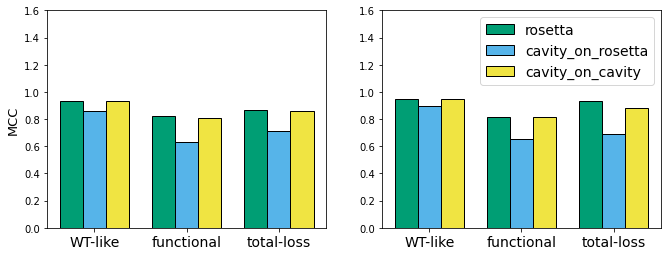

In [764]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(11,4))
X = np.arange(3)

ax1.bar(X + -0.25, CYP2C9_MCC_compare[0][1], color = '#009e74', width = 0.25,edgecolor='k')
ax1.bar(X + 0.0, CYP2C9_MCC_compare[2][1], color = '#56b4e9', width = 0.25,edgecolor='k')
ax1.bar(X + 0.25, CYP2C9_MCC_compare[4][1], color = '#f0e442', width = 0.25,edgecolor='k')

ax2.bar(X + -0.25, CYP2C9_MCC_compare[1][1], color = '#009e74', width = 0.25,label='rosetta',edgecolor='k')
ax2.bar(X + 0.0, CYP2C9_MCC_compare[3][1], color = '#56b4e9', width = 0.25,label='cavity_on_rosetta',edgecolor='k')
ax2.bar(X + 0.25, CYP2C9_MCC_compare[5][1], color = '#f0e442', width = 0.25,label='cavity_on_cavity',edgecolor='k')

ax1.set_xticks(X)
ax1.set_xticklabels(['WT-like','functional','total-loss'],fontsize=14)
ax2.set_xticks(X)
ax2.set_xticklabels(['WT-like','functional','total-loss'],fontsize=14)
ax1.set_ylabel('MCC',fontsize=13)
ax2.legend(fontsize=14)
ax1.set_ylim(0,1.6)
ax2.set_ylim(0,1.6)
plt.savefig('./Figures/CYP2C9_cavity_rosetta_comparison.pdf')

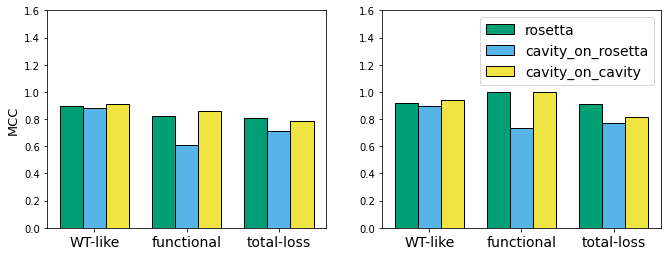

In [765]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(11,4))
X = np.arange(3)

ax1.bar(X + -0.25, NUDT15_MCC_compare[0][1], color = '#009e74', width = 0.25,edgecolor='k')
ax1.bar(X + 0.0, NUDT15_MCC_compare[2][1], color = '#56b4e9', width = 0.25,edgecolor='k')
ax1.bar(X + 0.25, NUDT15_MCC_compare[4][1], color = '#f0e442', width = 0.25,edgecolor='k')

ax2.bar(X + -0.25, NUDT15_MCC_compare[1][1], color = '#009e74', width = 0.25,label='rosetta',edgecolor='k')
ax2.bar(X + 0.0, NUDT15_MCC_compare[3][1], color = '#56b4e9', width = 0.25,label='cavity_on_rosetta',edgecolor='k')
ax2.bar(X + 0.25, NUDT15_MCC_compare[5][1], color = '#f0e442', width = 0.25,label='cavity_on_cavity',edgecolor='k')

ax1.set_xticks(X)
ax1.set_xticklabels(['WT-like','functional','total-loss'],fontsize=14)
ax2.set_xticks(X)
ax2.set_xticklabels(['WT-like','functional','total-loss'],fontsize=14)
ax1.set_ylabel('MCC',fontsize=13)
ax2.legend(fontsize=14)
ax1.set_ylim(0,1.6)
ax2.set_ylim(0,1.6)
plt.savefig('./Figures/NUDT15_cavity_rosetta_comparison.pdf')

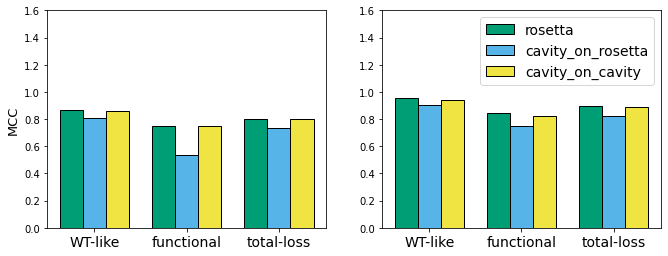

In [766]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(11,4))
X = np.arange(3)

ax1.bar(X + -0.25, PTEN_MCC_compare[0][1], color = '#009e74', width = 0.25,edgecolor='k')
ax1.bar(X + 0.0, PTEN_MCC_compare[2][1], color = '#56b4e9', width = 0.25,edgecolor='k')
ax1.bar(X + 0.25, PTEN_MCC_compare[4][1], color = '#f0e442', width = 0.25,edgecolor='k')

ax2.bar(X + -0.25, PTEN_MCC_compare[1][1], color = '#009e74', width = 0.25,label='rosetta',edgecolor='k')
ax2.bar(X + 0.0, PTEN_MCC_compare[3][1], color = '#56b4e9', width = 0.25,label='cavity_on_rosetta',edgecolor='k')
ax2.bar(X + 0.25, PTEN_MCC_compare[5][1], color = '#f0e442', width = 0.25,label='cavity_on_cavity',edgecolor='k')

ax1.set_xticks(X)
ax1.set_xticklabels(['WT-like','functional','total-loss'],fontsize=14)
ax2.set_xticks(X)
ax2.set_xticklabels(['WT-like','functional','total-loss'],fontsize=14)
ax1.set_ylabel('MCC',fontsize=13)
ax2.legend(fontsize=14)
ax1.set_ylim(0,1.6)
ax2.set_ylim(0,1.6)
plt.savefig('./Figures/PTEN_cavity_rosetta_comparison.pdf')

In [189]:
model_name=['FM-rosetta','RaSP on FM-rosetta']
kcross_F1=[0.56,0.44]
precision_SH3_func=[0.500,0.3]
recall_SH3_func=[0.8,0.400]
F1_SH3_func=[0.714,0.350]
precision_SH3=[0.844,0.733]
recall_SH3=[0.750,0.680]
F1_SH3=[0.757,0.680]

In [190]:
FM_rosetta_pd_stats=pd.DataFrame({'kcross':kcross_F1,'precision_funct':precision_SH3_func,'recall_funct':recall_SH3_func,'F1_funct':F1_SH3_func,'precision':precision_SH3,'recall':recall_SH3,'F1':F1_SH3},index=model_name)

In [191]:
FM_rosetta_pd_stats_T=FM_rosetta_pd_stats.T

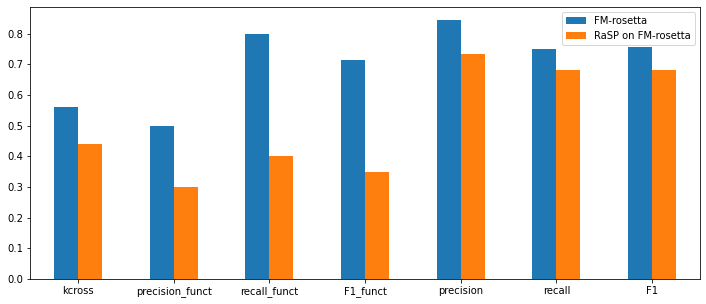

In [192]:
fig,ax1=plt.subplots(1,figsize=(12,5))
FM_rosetta_pd_stats_T.plot.bar(rot=0,ax=ax1)
plt.savefig('./Figures/RaSP_onFMrosetta__comparison_SH3.pdf')